In [1]:
import sys
sys.path.insert(0, "../../core/")

from os.path import join
from collections import namedtuple
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pickle import load
from scipy.stats import chi2

# PLEnuM tools
import settings as st
from tools import get_mids
from fluxes import ngc_flux, ngc_cut_flux, PL_flux, PLcut_flux, power_law, cut_off
from aeff_calculations import get_aeff_and_binnings

# plot settings
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# plt.style.use("../../style.mplstyle")

plot_path = "plots/ngc_paper"

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Time evolution

## Spectral discrimination potential --- breakdown

In [27]:
flux_sd = pd.read_csv(join(st.BASEPATH, "resources/source_spectrum_time-evolution.csv"))
sigma_ref = 3

flux_sd.scaled_flux = 1e13 * flux_sd.dp_flux
flux_sd.rename(columns={"dec_label": "Declination"}, inplace=True)
flux_sd["Era"] = ""
flux_sd.loc[flux_sd.era == "IceCube", "Era"] = r"IceCube-only"
flux_sd.loc[flux_sd.era == "Plenum-1", "Era"] = r"PLE$\nu$M-1"
flux_sd.loc[flux_sd.era == "Plenum-2", "Era"] = r"PLE$\nu$M-2"
flux_sd.loc[flux_sd.era == "Plenum-3", "Era"] = r"PLE$\nu$M-3"

# generate min flux, which corresponds to ideal time evolution with all detectors
flux_sd_min = (
    flux_sd.loc[flux_sd.sigma == sigma_ref]
    .groupby(["Year", "dec"])
    .apply(lambda x: x.loc[x.dp_flux == x.dp_flux.min()])
)

# set plenum-2 in southern hemisphere to 0, since it's degenerate with plenum-1
flux_sd.loc[
    (flux_sd.era == "Plenum-2")
    & (flux_sd.dec == -30)
    & (flux_sd.sigma == sigma_ref),
    ["dp_flux", "scaled_flux"],
] = 0

In [28]:
colors_detectors = {
    "IceCube": "#D8F3DC",
    "IceCube-Gen2": "#52B788",
    "KM3NeT": "#B7E4C7",
    "Baikal-FVD": "#95D5B2",
    "P-ONE": "#74C69D",
    "NEON": "#4BAA7F",
    "TRIDENT": "#4BAA7F",
    "HUNT": "#4BAA7F",
}
icecube_ref_time = (
    st.LIVETIME_DAYS / 365
)  # approx. 9.7 Years of full detector (NGC 1068 analysis)

start_dates = [
    {
        "label": r"IceCube (IC)",
        "detector": "IceCube",
        "Year": 2020 - icecube_ref_time,
        "colors": colors_detectors["IceCube"],
        "end": 2035,
    },
    {
        "label": r"IceCube",
        "detector": "IceCube extrapolated",
        "Year": 2020 - icecube_ref_time,
        "colors": "0.8",
        "end": 2060,
    },  ## WIP
    {
        "label": r"+ KM3NeT (1 IC)",
        "detector": "KM3NeT",
        "Year": 2025,
        "colors": colors_detectors["KM3NeT"],
        "end": 2060,
    },
    {
        "label": r"+ Baikal-GVD (1 IC)",
        "detector": "Baikal-GVD",
        "Year": 2028,
        "colors": colors_detectors["Baikal-FVD"],
        "end": 2060,
    },
    {
        "label": r"+ P-ONE (1 IC)",
        "detector": "P-ONE",
        "Year": 2031,
        "colors": colors_detectors["P-ONE"],
        "end": 2060,
    },
    {
        "label": r"+ IceCube-Gen2 (7.5~IC)",
        "detector": "Gen-2",
        "Year": 2035,
        "colors": colors_detectors["IceCube-Gen2"],
        "end": 2060,
    },
    {
        "label": r"+ TRIDENT (7.5 IC)",
        "detector": "TRIDENT",
        "Year": 2040,
        "colors": colors_detectors["TRIDENT"],
        "end": 2060,
    },
    {
        "label": r"+ NEON (10 IC)",
        "detector": "NEON",
        "Year": 2040,
        "colors": colors_detectors["NEON"],
        "end": 2060,
    },
    {
        "label": r"+ HUNT (30 IC)",
        "detector": "HUNT",
        "Year": 2040,
        "colors": colors_detectors["HUNT"],
        "end": 2060,
    },
]
start_dates = pd.DataFrame(start_dates)
start_dates = start_dates.set_index("detector")
yr_max = 2050
Years = np.arange(2020, yr_max)


In [118]:
## config
exposure_config = pd.read_pickle(join(st.LOCALPATH, f"timeline_configs.pickle"))
config_selection = pd.DataFrame(
    [
        {"Year": 2020, "era": "IceCube"},
        {"Year": 2025, "era": "IceCube"},
        # {"Year": 2028, "era": "Plenum-1"},
        {"Year": 2030, "era": "Plenum-1"},
        # {"Year": 2031, "era": "Plenum-1"},
        {"Year": 2035, "era": "Plenum-1"},
        {"Year": 2040, "era": "Plenum-2"},
        {"Year": 2045, "era": "Plenum-3"},
        {"Year": 2050, "era": "Plenum-3"},
    ]
)
config_selection["exposure"] = 0
for _, cs in config_selection.iterrows():
    selection = exposure_config.loc[
        (exposure_config.Year == cs["Year"]) & (exposure_config.era == cs["era"])
    ]
    _sum = 0
    for ii, _det in enumerate(selection.detectors.iloc[0]):
        if _det=="TRIDENT":
            _sum += selection.timefactors.iloc[0][ii] * st.TRIDENT_FACTOR
        elif _det=="HUNT":
            _sum += selection.timefactors.iloc[0][ii] * st.HUNT_FACTOR
        elif _det=="NEON":
            _sum += selection.timefactors.iloc[0][ii] * st.NEON_FACTOR
        else:
            _sum += selection.timefactors.iloc[0][ii]
    config_selection.loc[_, "exposure"] = _sum * 10

## v1

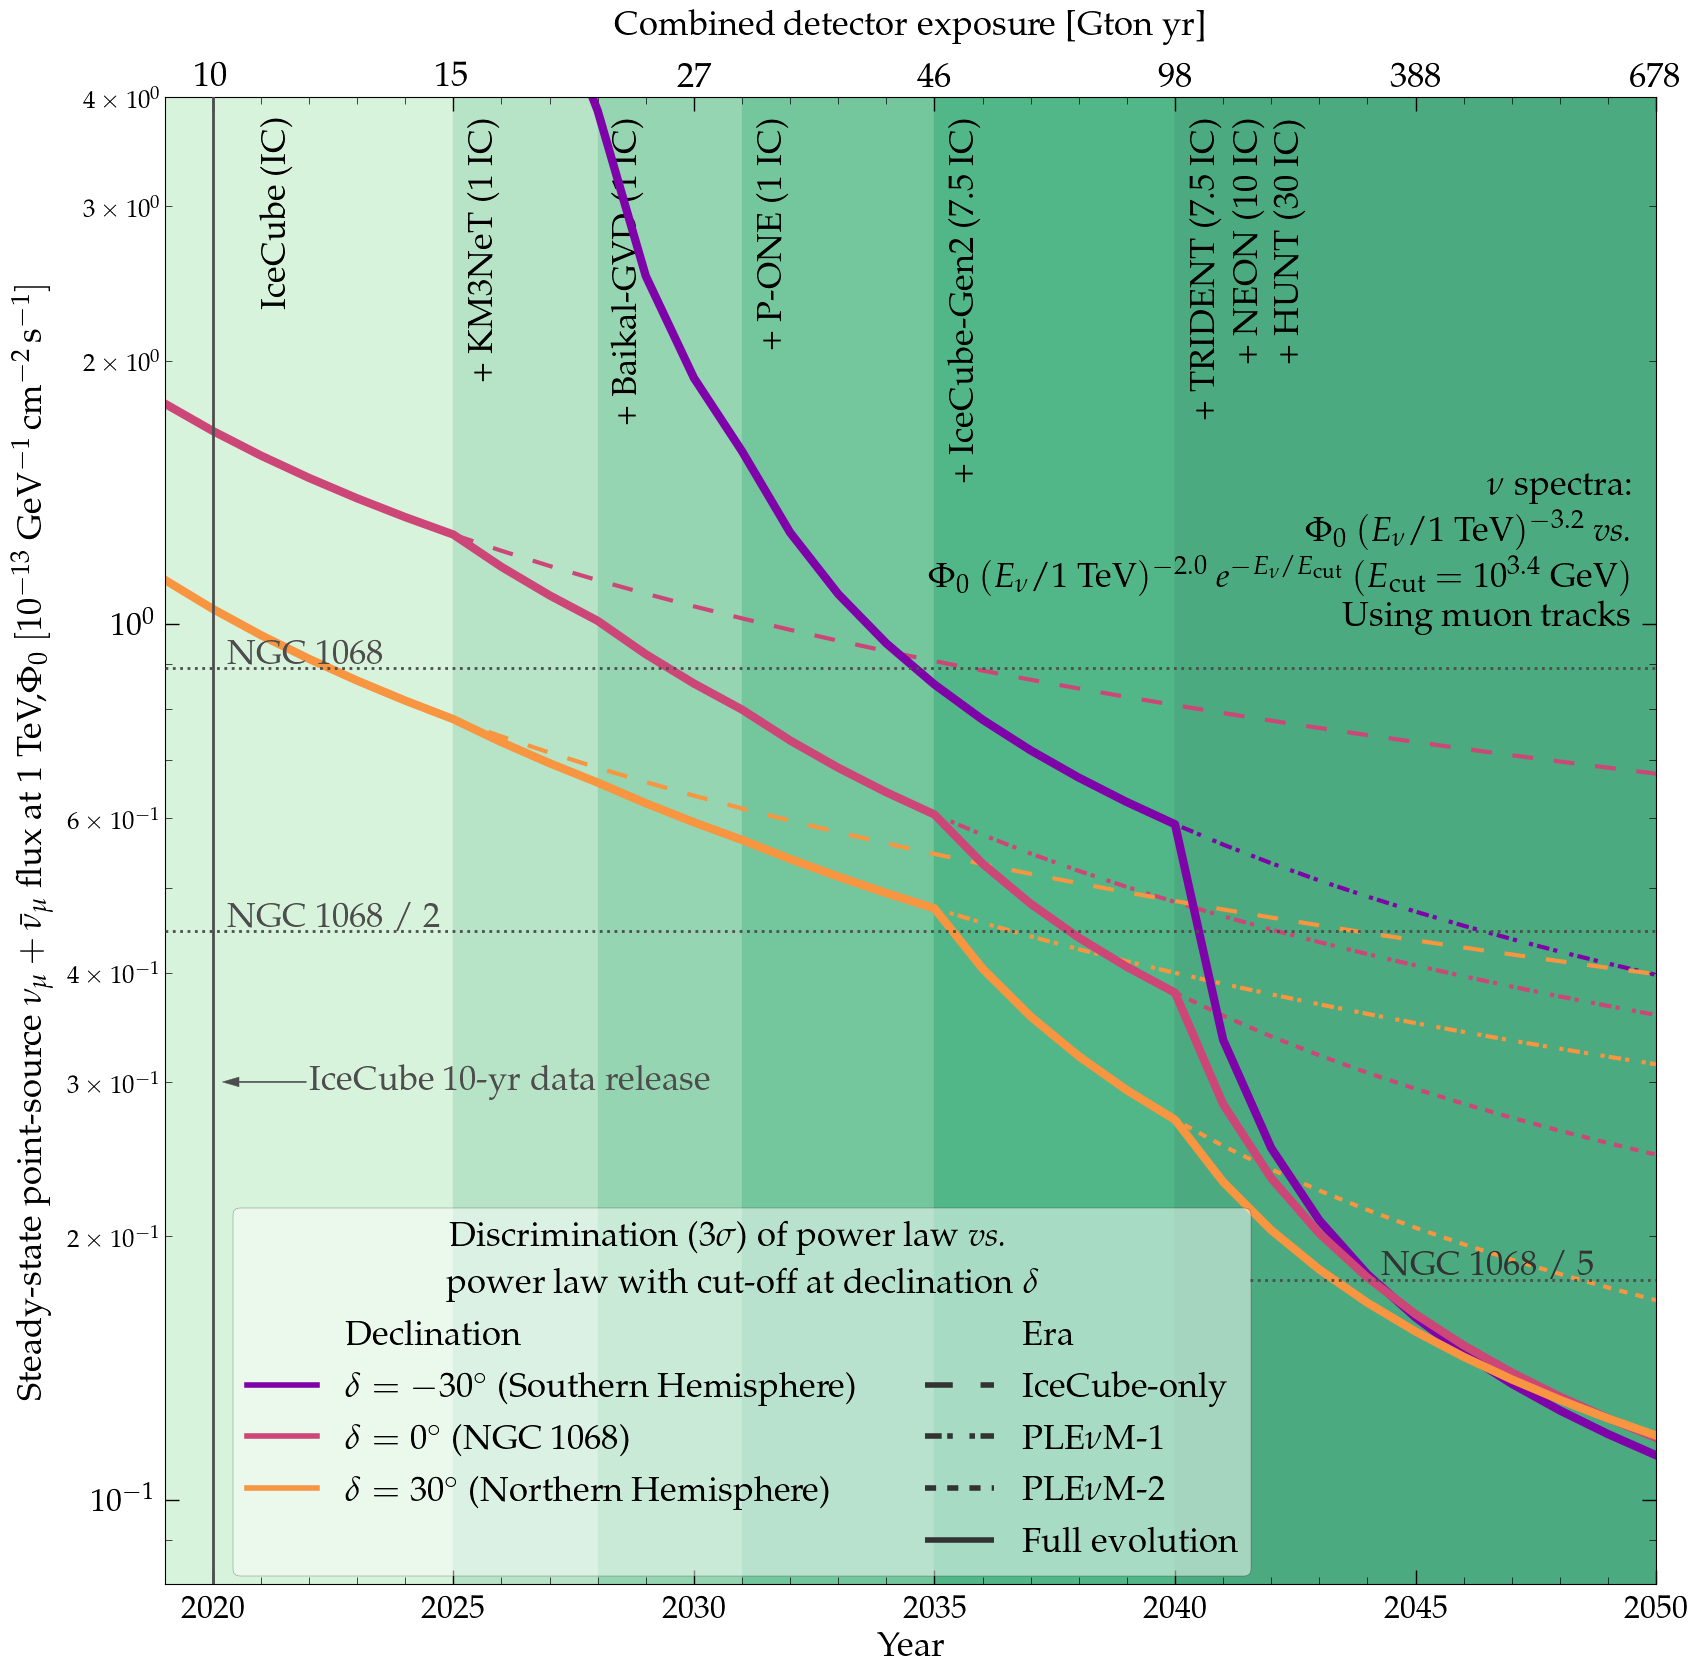

In [120]:
font_color = "0.3"

f, ax = plt.subplots(figsize=(19, 18))
_flux_sd = flux_sd
_flux_sd_min = flux_sd_min
_ymin = 0.08
_ymax = 4
_gamma = -3.2

for ii in [1, 2]:  # , 5]:
    ax.axhline(ngc_cut_flux.norm * 1e13 / ii, ls=":", lw=2, color=font_color, zorder=10)
    ax.text(
        x=2020 + 0.3,
        y=1.01 * ngc_cut_flux.norm * 1e13 / ii,
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize=25,  # "large",
        zorder=10,
    )
ii = 5
ax.plot(
    [2041.55, 2050],
    ngc_cut_flux.norm * 1e13 / ii * np.ones(2),
    ls=":",
    lw=2,
    color=font_color,
    zorder=10,
)
ax.text(
    x=2048.7,
    y=1.01 * ngc_cut_flux.norm * 1e13 / ii,
    s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
    ha="right",
    color="0.2",
    fontsize=25,
    zorder=10,
)

ax.annotate(
    r"$\nu$ spectra:"
    + "\n"
    + r"$\Phi_0~(E_\nu/{\rm 1~TeV})^{-3.2}$~{\it vs.}"
    + "\n"
    + r"$\Phi_0~(E_\nu/{\rm 1~TeV})^{-2.0}~e^{-E_\nu/E_{\rm cut}}~(E_{\rm cut} = 10^{3.4}~{\rm GeV})$"
    + "\n Using muon tracks",
    xy=(2049.5, 1.5),
    ha="right",
    va="top",
    zorder=10,
    color="k",
    fontsize=25,
)

width = 0.5e-1
_dashes = [(5, 5), (3, 1, 1), (2, 2), (1, 0)]

ax.axvline(2020, zorder=10, color=font_color)
ax.annotate(
    "IceCube 10-yr data release",
    (2020.2, 0.3),
    (2022, 0.3),
    ha="left",
    va="center",
    zorder=10,
    arrowprops=dict(width=1, headwidth=7, color=font_color),
    color=font_color,
    fontsize=25,  # "large",
)

for yr_i, series in start_dates.iterrows():
    if "extrapolated" in yr_i:
        continue
    length = 50 if not yr_i == "IceCube" else series.end - series.Year
    ax.fill_between(
        x=[series.Year, yr_max],
        y1=[_ymax * 1.5, _ymax * 1.5],
        y2=0.0,
        color=series.colors,
        zorder=0.3,
    )
    if yr_i == "IceCube":
        x = 2021
    elif yr_i == "NEON":
        x = series.Year + 1.2
    elif yr_i == "HUNT":
        x = series.Year + 2.05
    else:
        x = series.Year + 0.3
    ax.text(
        x=x,
        y=_ymax * 0.95,
        s=series.label,
        ha="left",
        va="top",
        fontsize=25,
        zorder=2,
        rotation=90,
    )

# evolution
ax = sns.lineplot(
    data=_flux_sd.loc[(_flux_sd.sigma == sigma_ref)],
    x="Year",
    y="scaled_flux",
    hue="Declination",
    hue_order=["-30°", "0°", "30°"],
    style="Era",
    style_order=["IceCube-only", r"PLE$\nu$M-1", r"PLE$\nu$M-2", r"PLE$\nu$M-3"],
    lw=3,
    legend=False,
    palette="plasma",
    dashes=_dashes,
)

# minimum
sns.lineplot(
    data=_flux_sd_min,
    x="Year",
    y="scaled_flux",
    hue="Declination",
    hue_order=["-30°", "0°", "30°"],
    lw=6,
    legend=False,
    palette="plasma",
)

# extra plotting for legend
ax.plot(np.NaN, np.NaN, "-", color="none", label=" ")
selection = _flux_sd.loc[(_flux_sd.sigma == sigma_ref) & (_flux_sd.Year == 2045)]
_hue_order = [
    r"$\delta = -30^\circ$~(Southern Hemisphere)",
    r"$\delta = 0^\circ$~(NGC 1068)",
    r"$\delta = 30^\circ$~(Northern Hemisphere)",
]

ax = sns.lineplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="Declination",
    hue_order=_hue_order,
    style_order=["IceCube-only", r"PLE$\nu$M-1", r"PLE$\nu$M-2", r"PLE$\nu$M-3"],
    style="Era",
    dashes=_dashes,
    lw=4,
    palette="plasma",
)
# re-ordering the legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 3, 4, 0, 5, 6, 7, 8, 9]
labels = [labels[idx] for idx in order]
labels[-1] = "Full evolution"
legend = ax.legend(
    [handles[idx] for idx in order],
    labels,
    bbox_to_anchor=(0.74, 0.265),
    framealpha=0.5,
    loc=1,
    title=r"\hspace*{-0.5em}Discrimination ($3\sigma$) of power law {\it vs.}\\[0.3em]power law with cut-off at declination $\delta$",
    ncol=2,
    fontsize=25,
    edgecolor="k",
    title_fontsize=25,
)
for line in legend.get_lines():
    line.set_linewidth(4)

# Top x-axis (artificial, for simplicity)
for _, row in config_selection.iterrows():
    ax.text(
        x=row.Year,# if row.Year < yr_max else yr_max - 1,
        y=_ymax * 1.03,
        s="{:0.0f}".format(row.exposure),
        fontsize=25,
        ha="center",
    )
ax.text(
    x=2034.5,
    y=_ymax * 1.18,
    s="Combined detector exposure [Gton~yr]",
    fontsize=25,
    ha="center",
)
ax.set_xlim(2019, yr_max)
ax.set_xlabel(r"Year", fontsize=25)
_yscaling = -13
ax.set_ylabel(
    r"Steady-state point-source $\nu_\mu + \bar{\nu}_\mu$ flux at 1~TeV,"
    + r"$\Phi_{0} ~ ["
    + rf"10^{{{_yscaling}}}"
    + r"~\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
    fontsize=25,
    labelpad=10,
)
plt.yticks(fontsize=23)
plt.xticks(fontsize=23)
ax.set_ylim(_ymin, _ymax)
ax.set_yscale("log")

ax.grid(alpha=0)
ax.yaxis.set_minor_locator(
    matplotlib.ticker.LogLocator(
        base=10.0, subs=np.arange(0.1, 1, step=0.1), numticks=12
    )
)
ax.yaxis.set_minor_formatter(
    matplotlib.ticker.LogFormatterSciNotation(minor_thresholds=(5, 1))
    # matplotlib.ticker.LogFormatterSciNotation(minor_thresholds=(3,4)) # shows all minor ticks
)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))


f.savefig(
    join(
        st.BASEPATH,
        plot_path,
        "time_evolution_significance_spectral_breakdown.pdf",
    ),
    dpi=300,
    bbox_inches="tight",
)

## v0

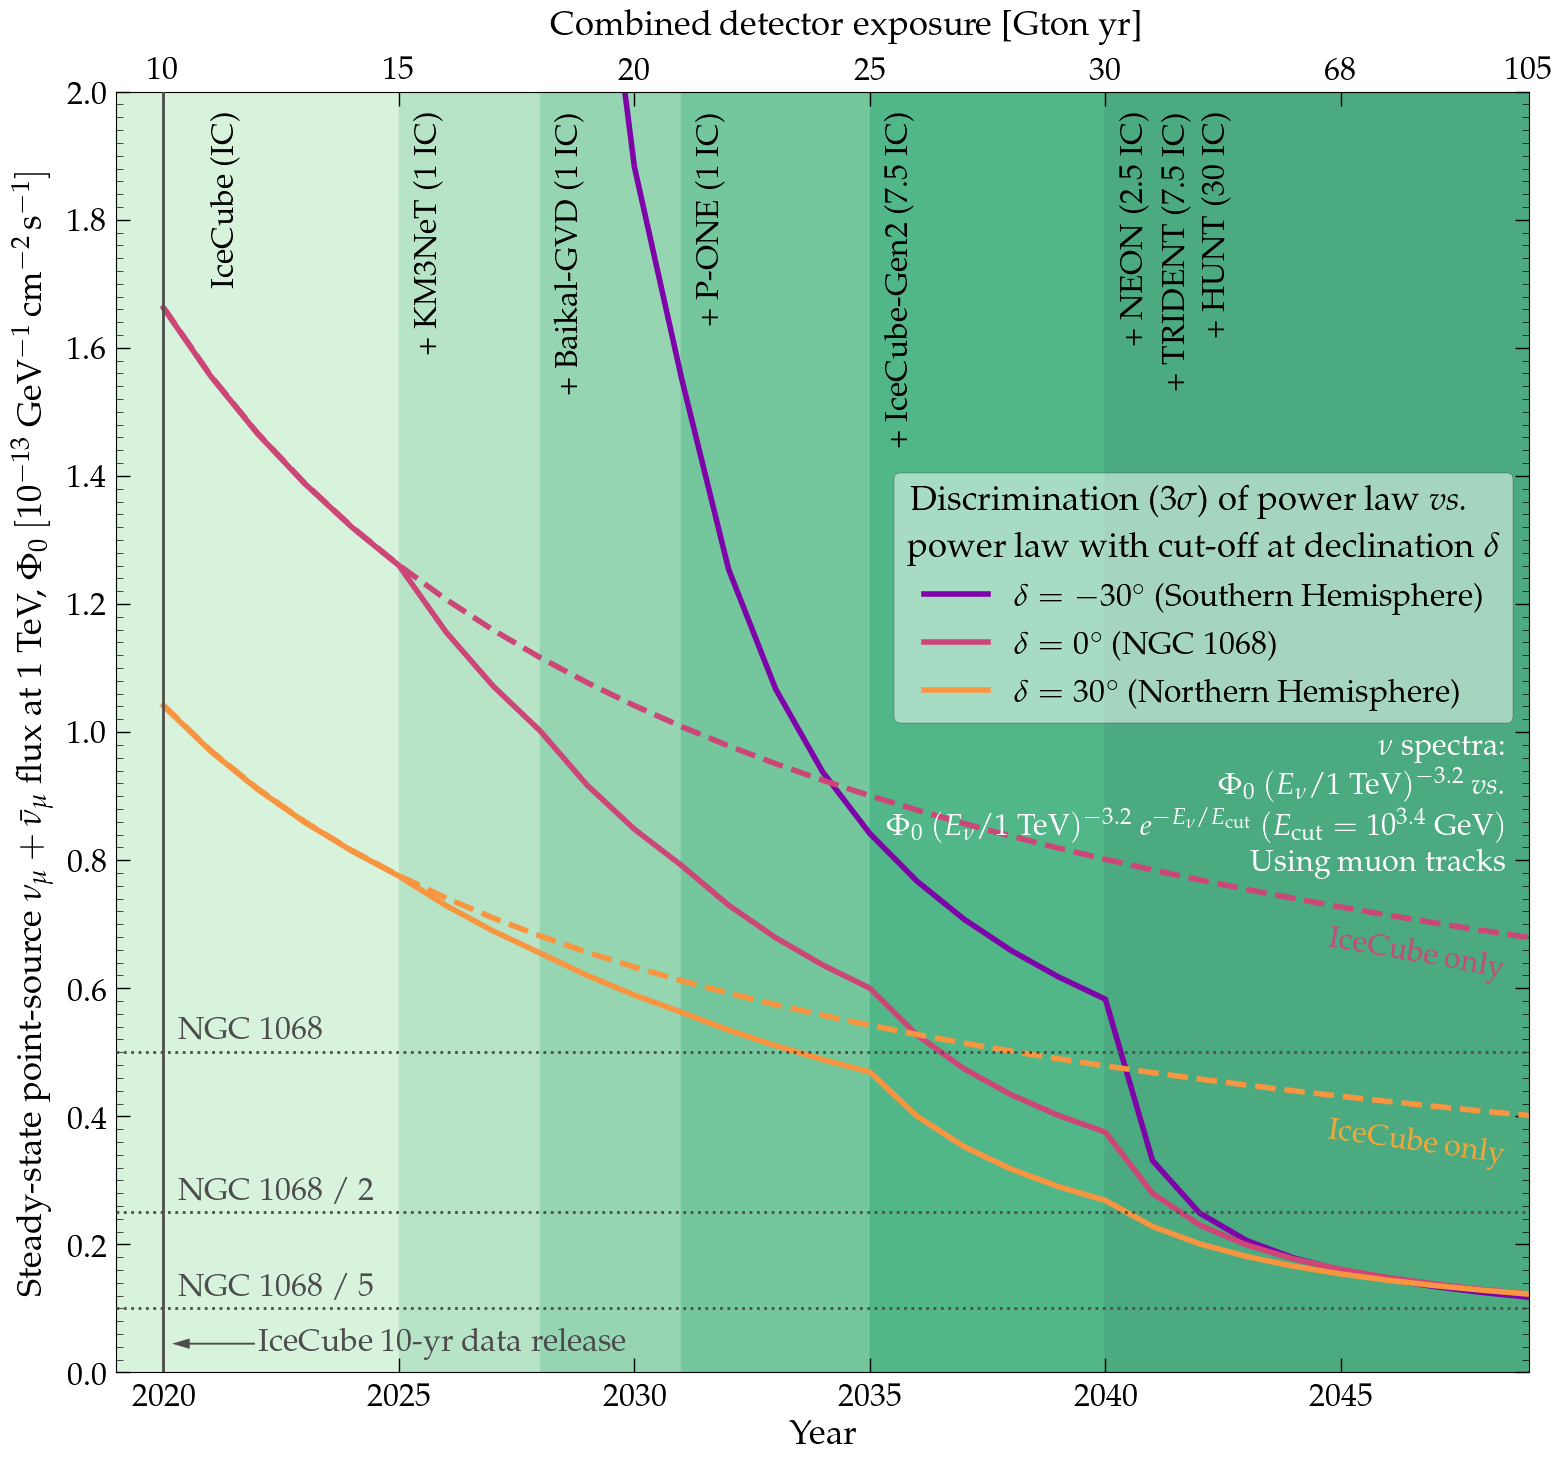

In [ ]:
f, ax = plt.subplots(figsize=(18, 15.5)) #22
# f, ax = plt.subplots(figsize=(6, 5))

edge = 1
ax.set_ylim(0, edge)
width = 0.5e-1  # 0.6e-1
font_color = "0.3"

ax.axvline(2020, zorder=10, color=font_color)
ax.annotate(
    "IceCube 10-yr data release",
    (2020.2, 0.045),
    (2022, 0.045),
    ha="left",
    va="center",
    zorder=10,
    arrowprops=dict(width=1, headwidth=7, color=font_color),
    color=font_color,
    fontsize=23,  # "large",
)
ax.annotate(
    r"$\nu$ spectra:"+'\n' 
    + r"$\Phi_0~(E_\nu/{\rm 1~TeV})^{-3.2}$~{\it vs.}"+'\n'
    + r"$\Phi_0~(E_\nu/{\rm 1~TeV})^{-3.2}~e^{-E_\nu/E_{\rm cut}}~(E_{\rm cut} = 10^{3.4}~{\rm GeV})$" 
    + "\n Using muon tracks",
    xy=(2048.5, 1.0),
    ha="right",
    va="top",
    zorder=10,
    color='w',
    fontsize=22,  # "large",
)

ax.annotate(
    r'IceCube only',
    xy=(2048.5, 0.7),
    ha="right",
    va="top",
    zorder=10,
    color=matplotlib.colormaps['plasma'](0.5),
    fontsize=22, 
    rotation=-10.
)
ax.annotate(
    r'IceCube only',
    xy=(2048.5, 0.4),
    ha="right",
    va="top",
    zorder=10,
    color=matplotlib.colormaps['plasma'](0.8),
    fontsize=22, 
    rotation=-8.
)



for yr_i, series in start_dates.iterrows():
    if "extrapolated" in yr_i:
        continue
    if not "Gen" in yr_i:
        edge -= width
    length = 50 if not yr_i == "IceCube" else series.end - series.Year
    ax.fill_between(
        x=[series.Year, yr_max], 
        y1=[3.0, 3.0],
        y2=0.0,
        color=series.colors,
        zorder=0.3
    )
    if yr_i == "IceCube":
        x = 2021
    elif yr_i == "TRIDENT":
        x = series.Year + 1.2
    elif yr_i == "HUNT":
        x = series.Year + 2.05
    else:
        x = series.Year + 0.3        
    ax.text(
        # x=series.Year + 0.3 if yr_i != "IceCube" else 2021,
        x=x,
        y=1.97,
        s=series.label,
        ha="left",
        va="top",
        fontsize=23,  # "x-large",
        zorder=2,
        rotation=90
    )
    
# plenum evolution
ax = sns.lineplot(
    data=flux_sd.loc[
        (flux_sd.sigma == sigma_ref) & (flux_sd.identifier == "PLEnuM")
    ],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    style="dec_label",
    units="dec",
    lw=4,
    legend=False,
    palette="plasma",
    dashes=False,
)
# icecube-only extrapolated
ax = sns.lineplot(
    data=flux_sd.loc[
        (flux_sd.sigma == sigma_ref) & (flux_sd.identifier == "IceCube extrapolated")
    ],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    units="dec",
    lw=4,
    ls="--",
    legend=False,
    palette="plasma",
)


# # plenum evolution markers
# selection = flux_sd.loc[
#     (flux_sd.sigma == sigma_ref) & (flux_sd.identifier == "PLEnuM")
# ]
# selection = selection.loc[(selection.Year < 2041) & (selection.Year % 5 == 0)]
# ax = sns.scatterplot(
#     data=selection,
#     x="Year",
#     y="scaled_flux",
#     hue="dec_label",
#     hue_order=["-30°", "0°", "30°"],
#     style="dec_label",
#     markers=["X", "s", "o"],
#     s=12**2,
#     palette="plasma",
#     ax=ax,
#     legend=False,
#     zorder=11,
# )
# extra plotting for legend
selection = flux_sd.loc[
    (flux_sd.sigma == sigma_ref) & (flux_sd.identifier == "PLEnuM")
]
selection = selection.loc[selection.Year == 2035]
ax = sns.lineplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=[
        r"$\delta = -30^\circ$~(Southern Hemisphere)",
        r"$\delta = 0^\circ$~(NGC 1068)",
        r"$\delta = 30^\circ$~(Northern Hemisphere)",
    ],
    style_order=[
        r"$\delta = -30^\circ$~(Southern Hemisphere)",
        r"$\delta = 0^\circ$~(NGC 1068)",
        r"$\delta = 30^\circ$~(Northern Hemisphere)",
    ],
    style="dec_label",
    units="dec",
    lw=4,
    ms=12,
    palette="plasma",
    # markers=["o", "X", "s"],
    dashes=False,
)
# IceCube extrapolated for legend
# plt.plot([-1, -3], [-1, -3], ls="--", lw=4, color="gray", label="IceCube only")

legend = ax.legend(
    bbox_to_anchor=(1.0, 0.715),
    # bbox_to_anchor=(1.0, 0.75),
    framealpha=0.5,
    loc=1,
    title=r"\hspace*{-0.5em}Discrimination ($3\sigma$) of power law {\it vs.}\\[0.3em]power law with cut-off at declination $\delta$",
    ncol=1,
    fontsize=23,
    edgecolor="k",
    title_fontsize=25
)
# plt.setp(legend.get_title(), fontsize=18)  # "x-large")
for line in legend.get_lines()[:]:
    line.set_linewidth(4)
    line.set_markersize(12)

# Top x-axis (artificial, for simplicity)
volume_ic = 1.0  # IceCube volume [Gton]
ic_start = 2010  # 2011


### UPDATE -- I think this was not right in the first place 
# ... it does not count the Northern detectors? Or do I see this wrong?
def exposure_combined(year):
    if year <= 2025:
        exposure = volume_ic * (year - ic_start)
    elif 2025 < year <= 2030:
        exposure = exposure_combined(2025) + (year - 2025) * volume_ic
    elif 2030 < year <= 2035:
        exposure = exposure_combined(2030) + (year - 2030) * volume_ic
    elif 2035 < year <= 2040:
        exposure = exposure_combined(2035) + (year - 2035) * volume_ic
    elif year > 2040:
        exposure = exposure_combined(2040) + (year - 2040) * 7.5 * volume_ic
    return exposure


for year in np.linspace(2020, 2050, 7):
    ax.text(
        x=year if year<yr_max else yr_max-1,
        y=2.02,
        s="{:0.0f}".format(exposure_combined(year)),
        fontsize=23,
        ha="center",
    )
ax.text(
    x=2034.5, y=2.09, s="Combined detector exposure [Gton~yr]", fontsize=25, ha="center"
)

ax.set_xlim(2019, yr_max - 1)
ax.set_ylim(0, 2.0)
ax.set_xlabel(r"Year", fontsize=25)
ax.set_ylabel(
    r"Steady-state point-source $\nu_\mu + \bar{\nu}_\mu$ flux at 1~TeV, $\Phi_{0} ~ [10^{-13}~\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
    fontsize=25,
    labelpad=10
)
plt.yticks(fontsize=23)
plt.xticks(fontsize=23)


for ii in [1, 2, 5]:
    ax.axhline(st.PHI_NGC * 1e13 / ii, ls=":", lw=2, color=font_color, zorder=10)
    ax.text(
        x=2020 + 0.3,
        y=0.02 + st.PHI_NGC * 1e13 / ii,
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize=23,  # "large",
        zorder=0.5,
    )

ax.grid(alpha=0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

# ax.set_title("Point-source discovery potential ($5 \sigma$)", fontsize="xx-large", pad=60)
f.savefig(
    join(st.BASEPATH, plot_path, "time_evolution_significance_spectral.pdf"),
    dpi=300,
    bbox_inches="tight",
)